# **Replication of the study from Nathan Nunn (2008)**

## **IV Group Members**:
### Colon, Christopher
### Rodriguez Quinto, Anel
### Stevens, Madison
### Stutts, Charlie
### Xu, Davis

In [133]:
!pip install linearmodels

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from statsmodels.sandbox.regression.gmm import IV2SLS
import linearmodels.iv.model as lm
from tabulate import tabulate

# Clone the repository
!git clone https://github.com/ECMT-680-Financial-Econometrics/IV-Group-Slave-Trade.git

# Navigate to the repository directory
%cd IV-Group-Slave-Trade

# List the files in the directory to verify the repository is cloned
#!ls

# Now you can load the data from the cloned repository
# For example, if the data is stored in a CSV file, you can use pandas to load it
df = pd.read_csv('slave_trade_QJE_New_Data.csv')

# print(df.columns)  # This will list all the columns in your DataFrame

Cloning into 'IV-Group-Slave-Trade'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 12), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 261.00 KiB | 5.67 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/IV-Group-Slave-Trade/IV-Group-Slave-Trade/IV-Group-Slave-Trade/IV-Group-Slave-Trade


# **Table 3: OLS Regressions**

In [134]:
# Table 3: OLS regression with and without controls
X1 = sm.add_constant(df[['ln_export_area', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X2 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X4 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'region_n',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X5 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'legor_uk', 'region_n', 'ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])

# Fit the models
model1 = sm.OLS(df['ln_maddison_pcgdp2000'], X1).fit()
model2 = sm.OLS(df['ln_maddison_pcgdp2000'], X2).fit()
model4 = sm.OLS(df['ln_maddison_pcgdp2000'], X4).fit()
model5 = sm.OLS(df['ln_maddison_pcgdp2000'], X5).fit()

# Extract coefficients and other statistics for the specified variables
variables = ['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp',
             'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'legor_uk', 'region_n',
             'ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']

results = []

# Populate the results list
for var in variables:
    row_values = {'Variable': var}
    for i, model in enumerate([model1, model2, model4, model5]):
        if var in model.params:
            coefficient = round(model.params[var], 3)
            std_error = round(model.bse[var], 3)
            p_value = round(model.pvalues[var], 3)
            std_p_value = f"{std_error} ({p_value})"
            row_values[f'Model {i+1} Coefficient'] = coefficient
            row_values[f'Model {i+1} Std. Error (P-value)'] = std_p_value
        else:
            row_values[f'Model {i+1} Coefficient'] = ''
            row_values[f'Model {i+1} Std. Error (P-value)'] = ''
    results.append(row_values)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Convert NaN values to empty strings
results_df = results_df.replace({np.nan: ''})

# Convert the DataFrame to a tabular format with fancy styling
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False)

# Print the table
print(table)


╒═════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╕
│ Variable                │ Model 1 Coefficient   │ Model 1 Std. Error (P-value)   │ Model 2 Coefficient   │ Model 2 Std. Error (P-value)   │ Model 3 Coefficient   │ Model 3 Std. Error (P-value)   │   Model 4 Coefficient │ Model 4 Std. Error (P-value)   │
╞═════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╡
│ ln_export_area          │ -0.112                │ 0.024 (0.0)                    │ -0.076                │ 0.029 (0.013)                  │ -0.085                │ 0.035 (0.02)                   │                -0.103 │ 0.034 (0.

# **Table 4: IV and 2SLS**

**Model 1**

In [135]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model1 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model1.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model1.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model1 = sm.OLS(df['ln_maddison_pcgdp2000'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model1.summary())


In [136]:
# Extracting coefficients and standard errors for the first stage
coefficients = first_stage_model1.params
std_errors = first_stage_model1.bse

# Create a DataFrame with coefficients and standard errors
first_stage_results_df = pd.DataFrame({'Variable': coefficients.index, 'Coefficient': coefficients.values, 'Std. Error': std_errors.values})

# Round the numbers to three decimals
first_stage_results_df = first_stage_results_df.round(3)

# Print the name of the first stage
print("First Stage Results:")
# Print the table
print(tabulate(first_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model1.params
std_errors_second_stage = second_stage_model1.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

First Stage Results:
╒═══════════════════════════╤═══════════════╤══════════════╕
│ Variable                  │   Coefficient │   Std. Error │
╞═══════════════════════════╪═══════════════╪══════════════╡
│ const                     │        29.11  │        6.959 │
├───────────────────────────┼───────────────┼──────────────┤
│ atlantic_distance_minimum │        -1.314 │        0.357 │
├───────────────────────────┼───────────────┼──────────────┤
│ indian_distance_minimum   │        -1.095 │        0.38  │
├───────────────────────────┼───────────────┼──────────────┤
│ saharan_distance_minimum  │        -2.435 │        0.823 │
├───────────────────────────┼───────────────┼──────────────┤
│ red_sea_distance_minimum  │        -0.002 │        0.71  │
╘═══════════════════════════╧═══════════════╧══════════════╛

Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │   Coefficient │   Std. Error │
╞══════════════════════════╪═══════════════

**Model 2**

In [137]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model2 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model2.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model2.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model2 = sm.OLS(df['ln_maddison_pcgdp2000'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model2.summary())


In [138]:
# Extracting coefficients and standard errors for the first stage
coefficients = first_stage_model2.params
std_errors = first_stage_model2.bse

# Create a DataFrame with coefficients and standard errors
first_stage_results_df = pd.DataFrame({'Variable': coefficients.index, 'Coefficient': coefficients.values, 'Std. Error': std_errors.values})

# Round the numbers to three decimals
first_stage_results_df = first_stage_results_df.round(3)

# Exclude colony variables from the first stage results table
first_stage_results_df = first_stage_results_df[~first_stage_results_df['Variable'].str.startswith('colony')]

# Add "Colony Fixed Effects" to the first stage results table
colony_fixed_effects_row = pd.DataFrame({'Variable': ['Colony Fixed Effects'], 'Coefficient': ['Yes'], 'Std. Error': ['']})
first_stage_results_df = pd.concat([first_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Print the name of the first stage
print("First Stage Results:")
# Print the table
print(tabulate(first_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model2.params
std_errors_second_stage = second_stage_model2.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Exclude colony variables from the second stage results table
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].str.startswith('colony')]

# Add "Colony Fixed Effects" to the second stage results table
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


First Stage Results:
╒═══════════════════════════╤═══════════════╤══════════════╕
│ Variable                  │ Coefficient   │ Std. Error   │
╞═══════════════════════════╪═══════════════╪══════════════╡
│ const                     │ 42.363        │ 12.189       │
├───────────────────────────┼───────────────┼──────────────┤
│ atlantic_distance_minimum │ -1.741        │ 0.425        │
├───────────────────────────┼───────────────┼──────────────┤
│ indian_distance_minimum   │ -1.426        │ 0.531        │
├───────────────────────────┼───────────────┼──────────────┤
│ saharan_distance_minimum  │ -3.001        │ 1.049        │
├───────────────────────────┼───────────────┼──────────────┤
│ red_sea_distance_minimum  │ -0.152        │ 0.813        │
├───────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects      │ Yes           │              │
╘═══════════════════════════╧═══════════════╧══════════════╛

Second Stage Results:
╒══════════════════════════╤═════════════

**Model 3**

In [139]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum',
                             'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                             'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model3 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model3.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model3.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                        'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model3 = sm.OLS(df['ln_maddison_pcgdp2000'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model3.summary())

In [140]:
# Extract first stage results
coefficients_first_stage = first_stage_model3.params.round(3)
std_errors_first_stage = first_stage_model3.bse.round(3)

# Define variables to exclude
exclude_variables = ['colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']

# Create first stage results DataFrame
first_stage_results_df = pd.DataFrame({'Variable': coefficients_first_stage.index,
                                       'Coefficient': coefficients_first_stage.values,
                                       'Std. Error': std_errors_first_stage.values})

# Exclude specified variables
first_stage_results_df = first_stage_results_df[~first_stage_results_df['Variable'].isin(exclude_variables)]

# Add "Colony Fixed Effects" row
colony_fixed_effects_row = pd.DataFrame({'Variable': ['Colony Fixed Effects'], 'Coefficient': ['Yes'], 'Std. Error': ['']})
first_stage_results_df = pd.concat([first_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Add "Geography Controls" row
geography_controls_row = pd.DataFrame({'Variable': ['Geography Controls'], 'Coefficient': ['Yes'], 'Std. Error': ['']})
first_stage_results_df = pd.concat([first_stage_results_df, geography_controls_row], ignore_index=True)

# Print first stage table
print("\nFirst Stage Results:")
print(tabulate(first_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Extract second stage results
coefficients_second_stage = second_stage_model3.params.round(3)
std_errors_second_stage = second_stage_model3.bse.round(3)

# Create second stage results DataFrame
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index,
                                        'Coefficient': coefficients_second_stage.values,
                                        'Std. Error': std_errors_second_stage.values})

# Exclude specified variables
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].isin(exclude_variables)]

# Add "Colony Fixed Effects" row
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Add "Geography Controls" row
second_stage_results_df = pd.concat([second_stage_results_df, geography_controls_row], ignore_index=True)

# Print second stage table
print("\nSecond Stage Results:")
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))



First Stage Results:
╒═══════════════════════════╤═══════════════╤══════════════╕
│ Variable                  │ Coefficient   │ Std. Error   │
╞═══════════════════════════╪═══════════════╪══════════════╡
│ const                     │ 42.288        │ 19.336       │
├───────────────────────────┼───────────────┼──────────────┤
│ atlantic_distance_minimum │ -1.316        │ 0.761        │
├───────────────────────────┼───────────────┼──────────────┤
│ indian_distance_minimum   │ -1.081        │ 0.697        │
├───────────────────────────┼───────────────┼──────────────┤
│ saharan_distance_minimum  │ -1.139        │ 1.595        │
├───────────────────────────┼───────────────┼──────────────┤
│ red_sea_distance_minimum  │ -1.221        │ 1.82         │
├───────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects      │ Yes           │              │
├───────────────────────────┼───────────────┼──────────────┤
│ Geography Controls        │ Yes           │              │
╘═

## **Figures**

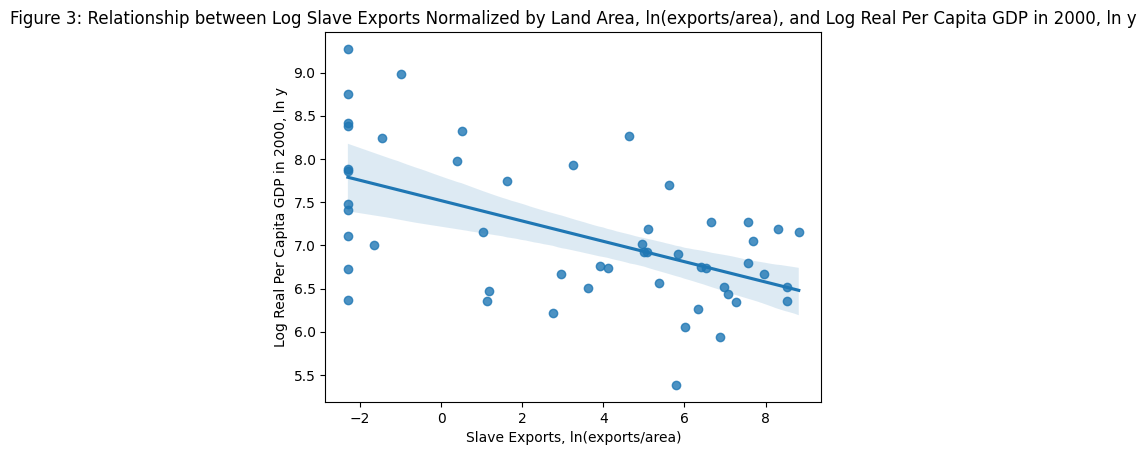

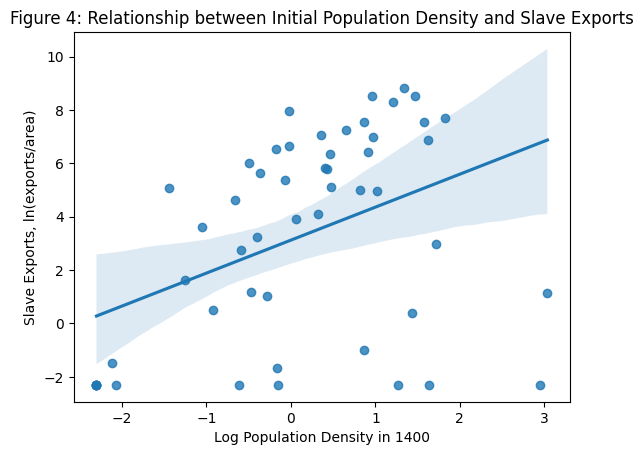

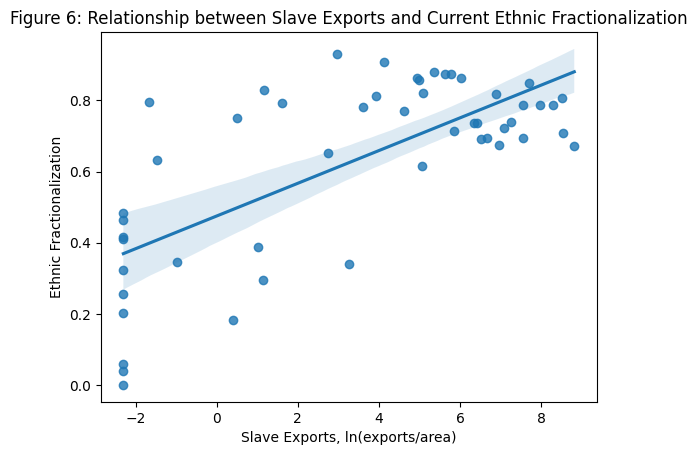

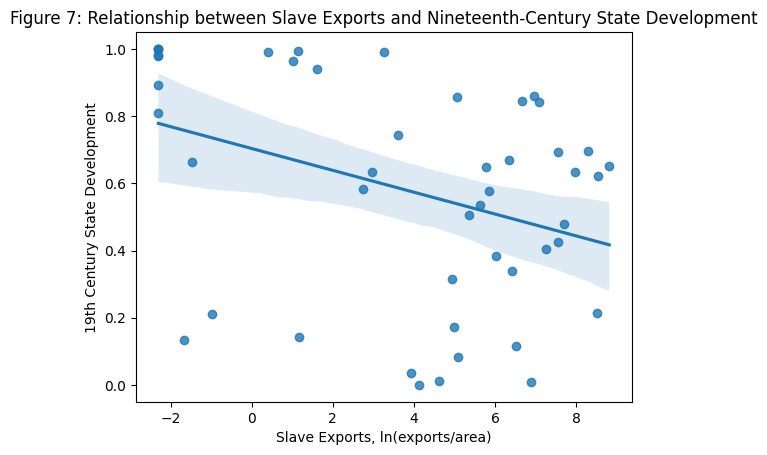

In [141]:
# Figure 3: Relationship between slaves exported per area and GDP
sns.regplot(x='ln_export_area', y='ln_maddison_pcgdp2000', data=df)
plt.title('Figure 3: Relationship between Log Slave Exports Normalized by Land Area, ln(exports/area), and Log Real Per Capita GDP in 2000, ln y')
plt.xlabel('Slave Exports, ln(exports/area)')
plt.ylabel('Log Real Per Capita GDP in 2000, ln y')
plt.show()

# Figure 4: Relationship between ln_pop_dens_1400 and slaves exported per area
# Assuming 'ethnic_fractionalization' is available in df
sns.regplot(x='ln_pop_dens_1400', y='ln_export_area', data=df)
plt.title('Figure 4: Relationship between Initial Population Density and Slave Exports')
plt.xlabel('Log Population Density in 1400')
plt.ylabel('Slave Exports, ln(exports/area)')
plt.show()

# Figure 6: Relationship between slaves exported per area and Ethnic Fractionalization
# Assuming 'ethnic_fractionalization' is available in df
sns.regplot(x='ln_export_area', y='ethnic_fractionalization', data=df)
plt.title('Figure 6: Relationship between Slave Exports and Current Ethnic Fractionalization')
plt.xlabel('Slave Exports, ln(exports/area)')
plt.ylabel('Ethnic Fractionalization')
plt.show()

# Figure 7: Relationship between slaves exported per area and Nineteenth-Century State Development
# Assuming 'ethnic_fractionalization' is available in df
sns.regplot(x='ln_export_area', y='state_dev', data=df)
plt.title('Figure 7: Relationship between Slave Exports and Nineteenth-Century State Development')
plt.xlabel('Slave Exports, ln(exports/area)')
plt.ylabel('19th Century State Development')
plt.show()


## **GDP 2001**

### OLS Regressions

In [142]:
# Table 3: OLS regression with and without controls
X1 = sm.add_constant(df[['ln_export_area', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X2 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X4 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'region_n',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])

# Fit the models
model1_gdp01 = sm.OLS(df['gpd01'], X1).fit()
model2_gdp01 = sm.OLS(df['gpd01'], X2).fit()
model4_gdp01 = sm.OLS(df['gpd01'], X4).fit()

# Extract coefficients and other statistics for the specified variables
variables = ['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp',
             'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'legor_uk', 'region_n',
             'ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']

results = []

# Populate the results list
for var in variables:
    row_values = {'Variable': var}
    for i, model in enumerate([model1_gdp01, model2_gdp01, model4_gdp01]):
        if var in model.params:
            coefficient = round(model.params[var], 3)
            std_error = round(model.bse[var], 3)
            p_value = round(model.pvalues[var], 3)
            std_p_value = f"{std_error} ({p_value})"
            row_values[f'Model {i+1} Coefficient'] = coefficient
            row_values[f'Model {i+1} Std. Error (P-value)'] = std_p_value
        else:
            row_values[f'Model {i+1} Coefficient'] = ''
            row_values[f'Model {i+1} Std. Error (P-value)'] = ''
    results.append(row_values)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Convert NaN values to empty strings
results_df = results_df.replace({np.nan: ''})

# Convert the DataFrame to a tabular format with fancy styling
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False)

# Print the table
print(table)


╒═════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╕
│ Variable                │ Model 1 Coefficient   │ Model 1 Std. Error (P-value)   │ Model 2 Coefficient   │ Model 2 Std. Error (P-value)   │ Model 3 Coefficient   │ Model 3 Std. Error (P-value)   │
╞═════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╡
│ ln_export_area          │ -0.115                │ 0.029 (0.0)                    │ -0.093                │ 0.036 (0.013)                  │ -0.101                │ 0.046 (0.034)                  │
├─────────────────────────┼───────────────────────┼────────────────────────────────┼───────────────────────┼────────────────────────────────┼───────────────────────┼────────────────────────────────┤
│ abs

### IV and 2SLS

**Model 1**

In [143]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model1 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model1.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model1.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model1_gdp01 = sm.OLS(df['gpd01'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model1_gdp01.summary())


In [144]:
# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model1_gdp01.params
std_errors_second_stage = second_stage_model1_gdp01.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │   Coefficient │   Std. Error │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │         7.933 │        0.218 │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │        -0.263 │        0.057 │
╘══════════════════════════╧═══════════════╧══════════════╛


**Model 2**

In [145]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model2 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model2.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model2.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model2_gdp01 = sm.OLS(df['gpd01'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model2_gdp01.summary())

In [146]:
# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model2_gdp01.params
std_errors_second_stage = second_stage_model2_gdp01.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Exclude colony variables from the second stage results table
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].str.startswith('colony')]

# Add "Colony Fixed Effects" to the second stage results table
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │ Coefficient   │ Std. Error   │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │ 9.651         │ 0.713        │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │ -0.23         │ 0.046        │
├──────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects     │ Yes           │              │
╘══════════════════════════╧═══════════════╧══════════════╛


**Model 3**

In [147]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum',
                             'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                             'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model3 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model3.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model3.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                        'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model3_gdp01 = sm.OLS(df['gpd01'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model3_gdp01.summary())

In [148]:
# Extract second stage results
coefficients_second_stage = second_stage_model3_gdp01.params.round(3)
std_errors_second_stage = second_stage_model3_gdp01.bse.round(3)

# Create second stage results DataFrame
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index,
                                        'Coefficient': coefficients_second_stage.values,
                                        'Std. Error': std_errors_second_stage.values})

# Exclude specified variables
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].isin(exclude_variables)]

# Add "Colony Fixed Effects" row
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Add "Geography Controls" row
second_stage_results_df = pd.concat([second_stage_results_df, geography_controls_row], ignore_index=True)

# Print second stage table
print("\nSecond Stage Results:")
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │ Coefficient   │ Std. Error   │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │ 12.074        │ 1.739        │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │ -0.41         │ 0.113        │
├──────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects     │ Yes           │              │
├──────────────────────────┼───────────────┼──────────────┤
│ Geography Controls       │ Yes           │              │
╘══════════════════════════╧═══════════════╧══════════════╛


## **GDP 2022**

### OLS Regressions

In [149]:
# Table 3: OLS regression with and without controls
X1 = sm.add_constant(df[['ln_export_area', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X2 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X4 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'region_n',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])

# Fit the models
model1_gdp22 = sm.OLS(df['gdp22'], X1).fit()
model2_gdp22 = sm.OLS(df['gdp22'], X2).fit()
model4_gdp22 = sm.OLS(df['gdp22'], X4).fit()

# Extract coefficients and other statistics for the specified variables
variables = ['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp',
             'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'legor_uk', 'region_n',
             'ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']

results = []

# Populate the results list
for var in variables:
    row_values = {'Variable': var}
    for i, model in enumerate([model1_gdp22, model2_gdp22, model4_gdp22]):
        if var in model.params:
            coefficient = round(model.params[var], 3)
            std_error = round(model.bse[var], 3)
            p_value = round(model.pvalues[var], 3)
            std_p_value = f"{std_error} ({p_value})"
            row_values[f'Model {i+1} Coefficient'] = coefficient
            row_values[f'Model {i+1} Std. Error (P-value)'] = std_p_value
        else:
            row_values[f'Model {i+1} Coefficient'] = ''
            row_values[f'Model {i+1} Std. Error (P-value)'] = ''
    results.append(row_values)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Convert NaN values to empty strings
results_df = results_df.replace({np.nan: ''})

# Convert the DataFrame to a tabular format with fancy styling
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False)

# Print the table
print(table)


╒═════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╕
│ Variable                │ Model 1 Coefficient   │ Model 1 Std. Error (P-value)   │ Model 2 Coefficient   │ Model 2 Std. Error (P-value)   │ Model 3 Coefficient   │ Model 3 Std. Error (P-value)   │
╞═════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╡
│ ln_export_area          │ -0.115                │ 0.029 (0.0)                    │ -0.083                │ 0.035 (0.023)                  │ -0.088                │ 0.044 (0.055)                  │
├─────────────────────────┼───────────────────────┼────────────────────────────────┼───────────────────────┼────────────────────────────────┼───────────────────────┼────────────────────────────────┤
│ abs

## IV and 2SLS

**Model 1**

In [150]:
# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model1 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model1.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model1.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model1_gdp22 = sm.OLS(df['gdp22'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model1_gdp22.summary())

In [151]:
# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model1_gdp22.params
std_errors_second_stage = second_stage_model1_gdp22.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │   Coefficient │   Std. Error │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │         8.155 │        0.211 │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │        -0.245 │        0.055 │
╘══════════════════════════╧═══════════════╧══════════════╛


**Model 2**

In [152]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model2 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model2.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model2.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model2_gdp22 = sm.OLS(df['gdp22'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model2_gdp22.summary())

In [153]:
# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model2_gdp22.params
std_errors_second_stage = second_stage_model2_gdp22.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Exclude colony variables from the second stage results table
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].str.startswith('colony')]

# Add "Colony Fixed Effects" to the second stage results table
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │ Coefficient   │ Std. Error   │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │ 9.349         │ 0.751        │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │ -0.213        │ 0.048        │
├──────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects     │ Yes           │              │
╘══════════════════════════╧═══════════════╧══════════════╛


**Model 3**

In [154]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum',
                             'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                             'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model3 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model3.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model3.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                        'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model3_gdp22 = sm.OLS(df['gdp22'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model3_gdp22.summary())

In [155]:
# Extract second stage results
coefficients_second_stage = second_stage_model3_gdp22.params.round(3)
std_errors_second_stage = second_stage_model3_gdp22.bse.round(3)

# Create second stage results DataFrame
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index,
                                        'Coefficient': coefficients_second_stage.values,
                                        'Std. Error': std_errors_second_stage.values})

# Exclude specified variables
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].isin(exclude_variables)]

# Add "Colony Fixed Effects" row
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Add "Geography Controls" row
second_stage_results_df = pd.concat([second_stage_results_df, geography_controls_row], ignore_index=True)

# Print second stage table
print("\nSecond Stage Results:")
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │ Coefficient   │ Std. Error   │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │ 11.013        │ 1.782        │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │ -0.337        │ 0.116        │
├──────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects     │ Yes           │              │
├──────────────────────────┼───────────────┼──────────────┤
│ Geography Controls       │ Yes           │              │
╘══════════════════════════╧═══════════════╧══════════════╛


## **Average GDP 2001 - 2022**

### OLS Regressions

In [156]:
# Table 3: OLS regression with and without controls
X1 = sm.add_constant(df[['ln_export_area', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X2 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])
X4 = sm.add_constant(df[['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'region_n',  'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']])

# Fit the models
model1_avg = sm.OLS(df['average_gdp_01_22'], X1).fit()
model2_avg = sm.OLS(df['average_gdp_01_22'], X2).fit()
model4_avg = sm.OLS(df['average_gdp_01_22'], X4).fit()

# Extract coefficients and other statistics for the specified variables
variables = ['ln_export_area', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp',
             'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'legor_uk', 'region_n',
             'ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']

results = []

# Populate the results list
for var in variables:
    row_values = {'Variable': var}
    for i, model in enumerate([model1_avg, model2_avg, model4_avg]):
        if var in model.params:
            coefficient = round(model.params[var], 3)
            std_error = round(model.bse[var], 3)
            p_value = round(model.pvalues[var], 3)
            std_p_value = f"{std_error} ({p_value})"
            row_values[f'Model {i+1} Coefficient'] = coefficient
            row_values[f'Model {i+1} Std. Error (P-value)'] = std_p_value
        else:
            row_values[f'Model {i+1} Coefficient'] = ''
            row_values[f'Model {i+1} Std. Error (P-value)'] = ''
    results.append(row_values)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Convert NaN values to empty strings
results_df = results_df.replace({np.nan: ''})

# Convert the DataFrame to a tabular format with fancy styling
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False)

# Print the table
print(table)


╒═════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╤═══════════════════════╤════════════════════════════════╕
│ Variable                │ Model 1 Coefficient   │ Model 1 Std. Error (P-value)   │ Model 2 Coefficient   │ Model 2 Std. Error (P-value)   │ Model 3 Coefficient   │ Model 3 Std. Error (P-value)   │
╞═════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╡
│ ln_export_area          │ -0.114                │ 0.028 (0.0)                    │ -0.086                │ 0.035 (0.02)                   │ -0.087                │ 0.045 (0.061)                  │
├─────────────────────────┼───────────────────────┼────────────────────────────────┼───────────────────────┼────────────────────────────────┼───────────────────────┼────────────────────────────────┤
│ abs

## IV and 2SLS

**Model 1**

In [157]:
# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model1 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model1.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model1.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model1_avg = sm.OLS(df['average_gdp_01_22'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model1_avg.summary())

In [158]:
# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model1_avg.params
std_errors_second_stage = second_stage_model1_avg.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │   Coefficient │   Std. Error │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │         8.112 │        0.217 │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │        -0.259 │        0.056 │
╘══════════════════════════╧═══════════════╧══════════════╛


**Model 2**

In [159]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model2 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model2.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model2.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model2_avg = sm.OLS(df['average_gdp_01_22'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model2_avg.summary())

In [160]:
# Extracting coefficients and standard errors for the second stage
coefficients_second_stage = second_stage_model2_avg.params
std_errors_second_stage = second_stage_model2_avg.bse

# Create a DataFrame with coefficients and standard errors for the second stage
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index, 'Coefficient': coefficients_second_stage.values, 'Std. Error': std_errors_second_stage.values})

# Round the numbers to three decimals
second_stage_results_df = second_stage_results_df.round(3)

# Exclude colony variables from the second stage results table
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].str.startswith('colony')]

# Add "Colony Fixed Effects" to the second stage results table
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Print the name of the second stage
print("\nSecond Stage Results:")
# Print the table
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │ Coefficient   │ Std. Error   │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │ 9.61          │ 0.723        │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │ -0.221        │ 0.047        │
├──────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects     │ Yes           │              │
╘══════════════════════════╧═══════════════╧══════════════╛


**Model 3**

In [161]:
import statsmodels.api as sm

# Step 1: First Stage Regression
# Define the endogenous variable (to be instrumented) and the instrument
endog_first_stage = df['ln_export_area']
instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum',
                             'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                             'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the instrument
instrument_first_stage = sm.add_constant(instrument_first_stage)

# Fit the first stage regression
first_stage_model3 = sm.OLS(endog_first_stage, instrument_first_stage).fit()

# Print first stage results
# print("First Stage Results:")
# print(first_stage_model3.summary())

# Step 2: Predicted Values from First Stage
# Get the predicted values from the first stage
df['ln_export_area_predicted'] = first_stage_model3.predict()

# Step 3: Second Stage Regression
# Define the exogenous variable (including the predicted values from the first stage)
exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                        'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

# Add constant to the exogenous variables
exog_second_stage = sm.add_constant(exog_second_stage)

# Fit the second stage regression
second_stage_model3_avg = sm.OLS(df['average_gdp_01_22'], exog_second_stage).fit()

# Print second stage results
# print("\nSecond Stage Results:")
# print(second_stage_model3_avg.summary())

In [162]:
# Extract second stage results
coefficients_second_stage = second_stage_model3_avg.params.round(3)
std_errors_second_stage = second_stage_model3_avg.bse.round(3)

# Create second stage results DataFrame
second_stage_results_df = pd.DataFrame({'Variable': coefficients_second_stage.index,
                                        'Coefficient': coefficients_second_stage.values,
                                        'Std. Error': std_errors_second_stage.values})

# Exclude specified variables
second_stage_results_df = second_stage_results_df[~second_stage_results_df['Variable'].isin(exclude_variables)]

# Add "Colony Fixed Effects" row
second_stage_results_df = pd.concat([second_stage_results_df, colony_fixed_effects_row], ignore_index=True)

# Add "Geography Controls" row
second_stage_results_df = pd.concat([second_stage_results_df, geography_controls_row], ignore_index=True)

# Print second stage table
print("\nSecond Stage Results:")
print(tabulate(second_stage_results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Second Stage Results:
╒══════════════════════════╤═══════════════╤══════════════╕
│ Variable                 │ Coefficient   │ Std. Error   │
╞══════════════════════════╪═══════════════╪══════════════╡
│ const                    │ 11.555        │ 1.752        │
├──────────────────────────┼───────────────┼──────────────┤
│ ln_export_area_predicted │ -0.366        │ 0.114        │
├──────────────────────────┼───────────────┼──────────────┤
│ Colony Fixed Effects     │ Yes           │              │
├──────────────────────────┼───────────────┼──────────────┤
│ Geography Controls       │ Yes           │              │
╘══════════════════════════╧═══════════════╧══════════════╛
